In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as seabornInstance
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers import Dense
from sklearn.metrics import mean_squared_error
%matplotlib inline

Loading the Dataset

In [2]:
data_lstm=pd.read_csv("https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv")

Summarizing the Dataset

In [3]:
data_lstm.head()


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
data_lstm.describe()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
count,2035.000000,2035.000000,2035.000000,2035.000000,2035.00000,2.035000e+03,2035.000000
mean,149.713735,151.992826,147.293931,149.474251,149.45027,2.335681e+06,3899.980565
std,48.664509,49.413109,47.931958,48.732570,48.71204,2.091778e+06,4570.767877
min,81.100000,82.800000,80.000000,81.000000,80.95000,3.961000e+04,37.040000
25%,120.025000,122.100000,118.300000,120.075000,120.05000,1.146444e+06,1427.460000
50%,141.500000,143.400000,139.600000,141.100000,141.25000,1.783456e+06,2512.030000
75%,157.175000,159.400000,155.150000,156.925000,156.90000,2.813594e+06,4539.015000
max,327.700000,328.750000,321.650000,325.950000,325.75000,2.919102e+07,55755.080000


In [5]:
data_lstm.isnull()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
2030,False,False,False,False,False,False,False,False
2031,False,False,False,False,False,False,False,False
2032,False,False,False,False,False,False,False,False
2033,False,False,False,False,False,False,False,False


In [6]:
data_lstm.shape

(2035, 8)

In [7]:
df=data_lstm.reset_index()['Close']
df

0       233.75
1       233.25
2       234.25
3       236.10
4       233.30
         ...  
2030    118.65
2031    117.60
2032    120.65
2033    120.90
2034    121.55
Name: Close, Length: 2035, dtype: float64

Data Visualization

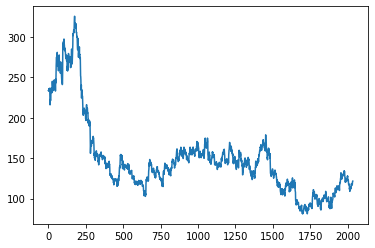

In [8]:
plt.plot(df)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5c68b4290>,
      dtype=object)

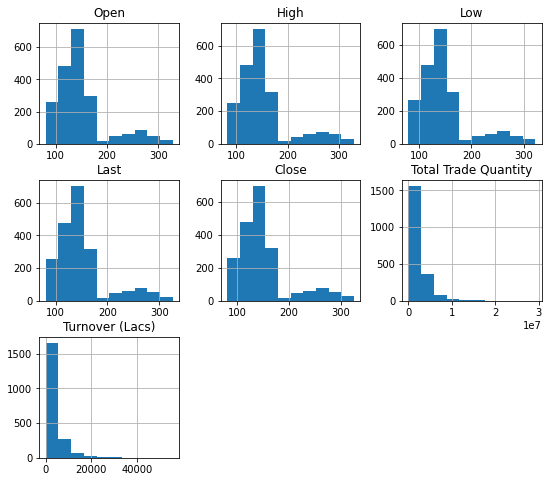

In [9]:
data_lstm.hist(figsize=(9,8))

In [10]:
scaler=MinMaxScaler(feature_range=(0,1))
df=scaler.fit_transform(np.array(df).reshape(-1,1))
print(df)

[[0.62418301]
 [0.62214052]
 [0.62622549]
 ...
 [0.1621732 ]
 [0.16319444]
 [0.16584967]]


Splitting dataset into train and test

In [11]:
training_size=int(len(df)*0.75)
test_size=len(df)-training_size
train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]

In [12]:
training_size,test_size

(1526, 509)

In [13]:
train_data

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.18831699],
       [0.18811275],
       [0.17034314]])

In [14]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [16]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

Building the Stacked LSTM Model

In [17]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 5, batch_size = 64, verbose = 1)

Epoch 1/5
23/23 [==============================] - 46s 841ms/step - loss: 0.0255 - val_loss: 0.0061
Epoch 2/5
23/23 [==============================] - 13s 578ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 3/5
23/23 [==============================] - 8s 341ms/step - loss: 0.0016 - val_loss: 0.0018
Epoch 4/5
23/23 [==============================] - 9s 406ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 5/5
23/23 [==============================] - 14s 605ms/step - loss: 0.0014 - val_loss: 0.0011


In [19]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

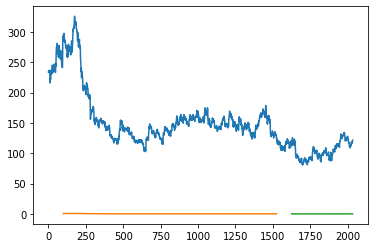

In [20]:
look_back = 100
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict
testPredictPlot = np.empty_like(df)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df) - 1, :] = test_predict
plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()


In [21]:
len(test_data)

509

In [22]:
x_input=test_data[341:].reshape(1,-1)
x_input.shape

(1, 168)

In [23]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [24]:
temp_input

[0.06801470588235292,
 0.0667892156862745,
 0.07414215686274506,
 0.0716911764705882,
 0.08639705882352938,
 0.08312908496732024,
 0.06311274509803921,
 0.06290849673202609,
 0.05167483660130712,
 0.031862745098039214,
 0.04003267973856206,
 0.03860294117647056,
 0.041053921568627416,
 0.033905228758169925,
 0.031249999999999944,
 0.026348039215686292,
 0.05861928104575159,
 0.06311274509803921,
 0.06209150326797386,
 0.055351307189542454,
 0.08455882352941174,
 0.05514705882352938,
 0.06045751633986923,
 0.055759803921568596,
 0.04391339869281047,
 0.029207516339869233,
 0.028186274509803877,
 0.04718137254901961,
 0.06045751633986923,
 0.05861928104575159,
 0.06168300653594766,
 0.06699346405228751,
 0.07087418300653592,
 0.07557189542483661,
 0.07700163398692805,
 0.10375816993464049,
 0.10314542483660127,
 0.10334967320261434,
 0.10089869281045749,
 0.1043709150326797,
 0.0980392156862745,
 0.09722222222222221,
 0.09783496732026142,
 0.09579248366013071,
 0.09109477124183002,
 0.09

In [25]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [26]:
math.sqrt(mean_squared_error(y_train,train_predict))

162.05593512745241

In [27]:
math.sqrt(mean_squared_error(y_test,test_predict))

109.1515310891707

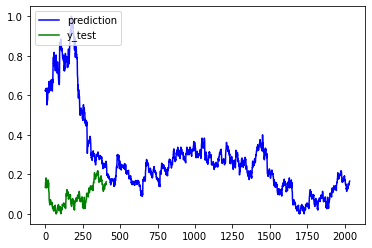

In [28]:
plt.plot(df,color='blue', label='prediction')
plt.plot(y_test,color='green', label='y_test')
plt.legend(loc='upper left')
plt.show()